In [59]:
from librosa import load
import numpy as np
import IPython
from matplotlib import pyplot as plt

from src.recorte import recortar

Ejercicio 1

In [60]:
AUDIO = './assets/estocastico.wav'

audio_signal, fs = load(AUDIO, sr=None)
print(f'fs={fs}, audio_signal.shape={audio_signal.shape}')

IPython.display.Audio(audio_signal, rate=fs)

fs=44100, audio_signal.shape=(88200,)


Ejercicio 2

In [5]:
markers = recortar(audio_signal, fs)


FloatSlider(value=5000.0, description='Inicio:', max=83200.0, min=5000.0, step=100.0)

FloatSlider(value=6000.0, description='Fin:', max=83200.0, min=5000.0, step=100.0)

Button(description='Reproducir segmento', style=ButtonStyle())

Button(description='Agregar marcador', style=ButtonStyle())

Output()

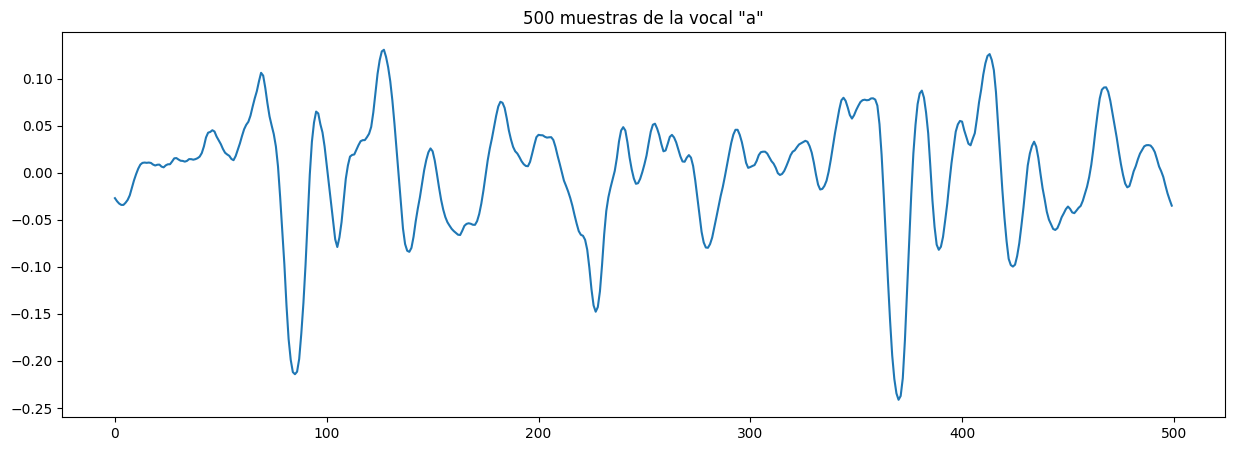

In [164]:
vowels = {
    'e':(28300, 32200), 
    'first_o':(40200, 44100), 
    'a':(47700, 49700), 
    'i':(58400, 60900), 
    'sec_o':(67200, 69200)}

a = audio_signal[vowels['a'][0]:vowels['a'][1]]

plt.figure(figsize=(15, 5))
plt.plot(a[500:1000])
plt.title('500 muestras de la vocal "a"')
plt.show()

Ejercicio 3

In [233]:
def lpc_compute(y: np.ndarray, order: int) -> np.ndarray:
    """
    Compute LPC coefficients.

    Parameters
    ----------
    y : np.ndarray
        Input signal.
    order : int
        Order of the LPC.

    Returns
    -------
    np.ndarray
        LPC coefficients.

    Raises
    ------
    ValueError
        If matrix inversion fails. 
    """
    autocor = np.correlate(y, y, mode='full')
    autocor = autocor[len(autocor)//2:] # positive lags

    r = autocor[1:order + 1]

    # Correlation matrix
    R = np.zeros((order, order))
    # Build the autocorrelation matrix R using autocor[0] as the main diagonal
    R = np.array(
        [[autocor[abs(i - j)] for j in range(order)] for i in range(order)]
    )
    try:
        R_inv = np.linalg.inv(R)
    except np.linalg.LinAlgError:
        raise ValueError("Matrix inversion failed.")
    
    return R_inv @ r

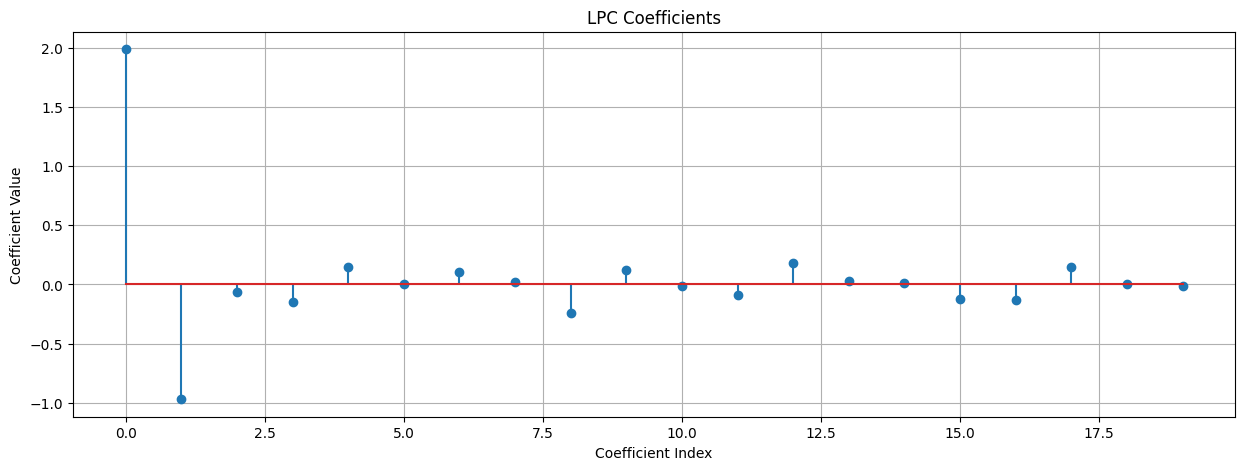

In [234]:
# tomo 500 samples de la vocal "a"
vowel_a = audio_signal[vowels['a'][0]:vowels['a'][1]] # vowel "a"

signal = vowel_a[500:1000]  # 500 samples

h = lpc_compute(signal, order=20)

plt.figure(figsize=(15, 5))
plt.stem(h)
plt.title('LPC Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.grid()
plt.show()

Ejercicio 5

In [235]:
def excitation_signal(y: np.ndarray, lpc_coeffs: np.ndarray) -> np.ndarray:
    """
    Computes an excitation signal from the vowel and its LPC coefficients.

    Parameters
    ----------
    y : np.ndarray
        The input vowel signal.
    lpc_coeffs : np.ndarray
        The LPC coefficients.

    Returns
    -------
    np.ndarray
        Excitation signal.
    """
    # The excitation is the difference between the original and predicted
    return y - np.convolve(y, lpc_coeffs, mode='same')


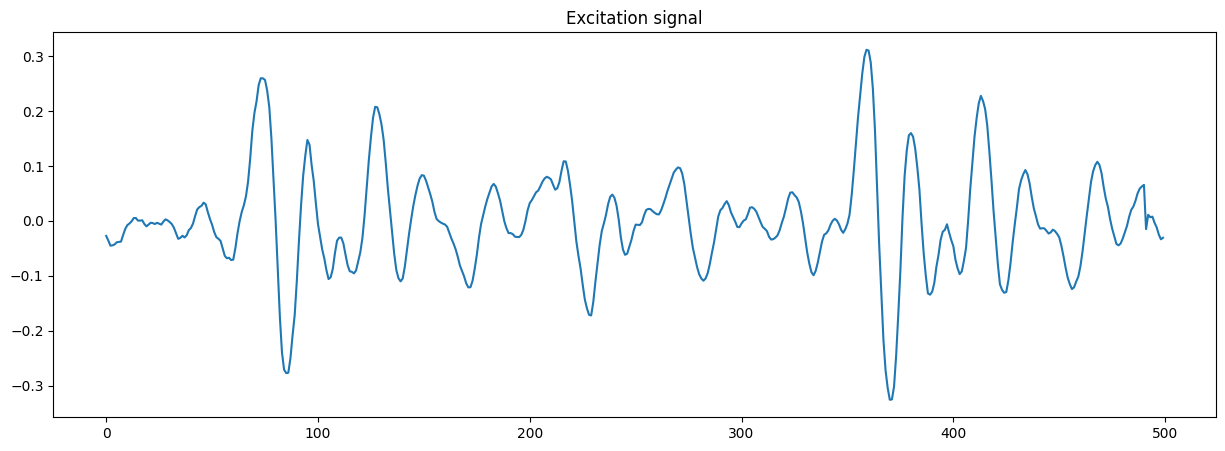

In [236]:
x_hat = excitation_signal(signal, h)
plt.figure(figsize=(15, 5))
plt.plot(x_hat)
plt.title('Excitation signal')
plt.show()

Ejercicio 8

![](./assets/img_ej_8.png)

In [281]:
def estimate_y_hat(
        x: np.ndarray, lpc_coeffs: np.ndarray) -> np.ndarray:
    """
    Estimate the original signal from the excitation and LPC coefficients.

    Parameters
    ----------
    x : np.ndarray
        The excitation signal.
    lpc_coeffs : np.ndarray
        The LPC coefficients.

    Returns
    -------
    np.ndarray
        Estimated original signal.
    """
    M = len(lpc_coeffs)
    y_hat = np.zeros_like(x)
    for n in range(len(x)):
        acc = 0
        # si tengo menos de M muestras estimadas en y[n], uso las que tengo.
        # y acoto el rango superior a M para no quedarme sin coeficientes.
        top_sample = min(M, n)
        for k in range(1, top_sample + 1):
            acc += lpc_coeffs[k - 1] * y_hat[n - k]
        y_hat[n] = x[n] + acc
    return y_hat
    

Al momento de graficar la senial reconstruida note que su amplitud es varios ordenes de magnitud mayorencima que la senial original. Desconozco a que se debe esto, pero al normalizar ambas seniales para que su maximo valor absoluto sea 1, la senial reconstruida se ve similar a la original, respetando la misma tendencia pero con un ligero desfasaje (esto ultimo era esperable ya que todos los filtros introducen un retardo de fase).

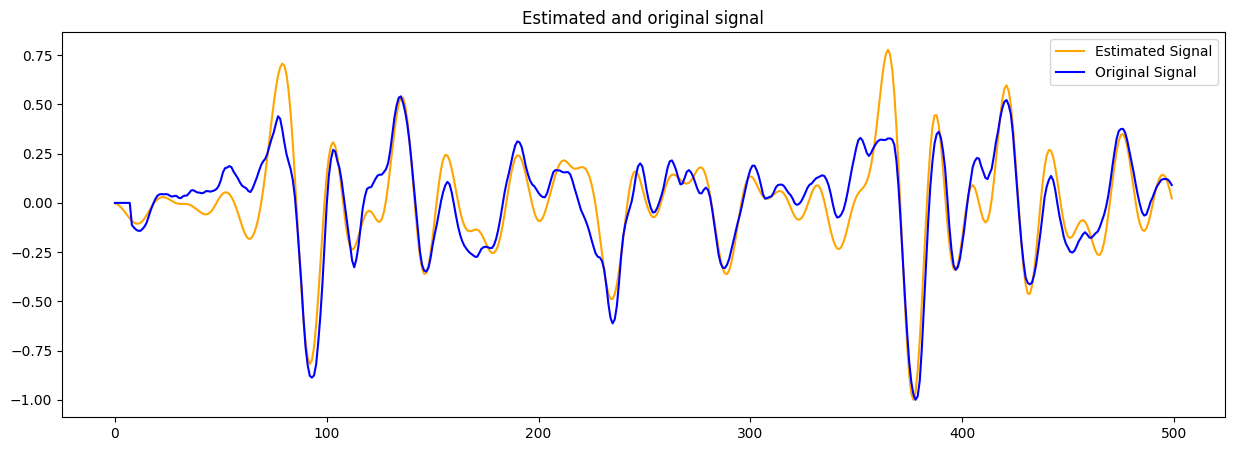

In [283]:
y_hat = estimate_y_hat(x=x_hat, lpc_coeffs=h)

y_hat_norm = y_hat / np.max(np.abs(y_hat))
signal_norm = signal / np.max(np.abs(signal))

# Ajustamos el desfasaje para graficar ambas señales alineadas
corr = np.correlate(y_hat_norm, signal_norm, mode='full')
lag = np.argmax(corr) - (len(signal_norm) - 1)
if lag > 0:
    signal_norm = np.pad(
        signal_norm, (lag, 0), mode='constant')[:len(signal_norm)]
elif lag < 0:
    signal_norm = np.pad(
        signal_norm, (0, -lag), mode='constant')[-lag:len(signal_norm)-lag]    


plt.figure(figsize=(15, 5))
plt.plot(y_hat_norm, color='orange')
plt.plot(signal_norm, color='blue')

plt.legend(['Estimated Signal', 'Original Signal', 'x_hat'])
plt.title('Estimated and original signal')
plt.show()

Ejercicio 9

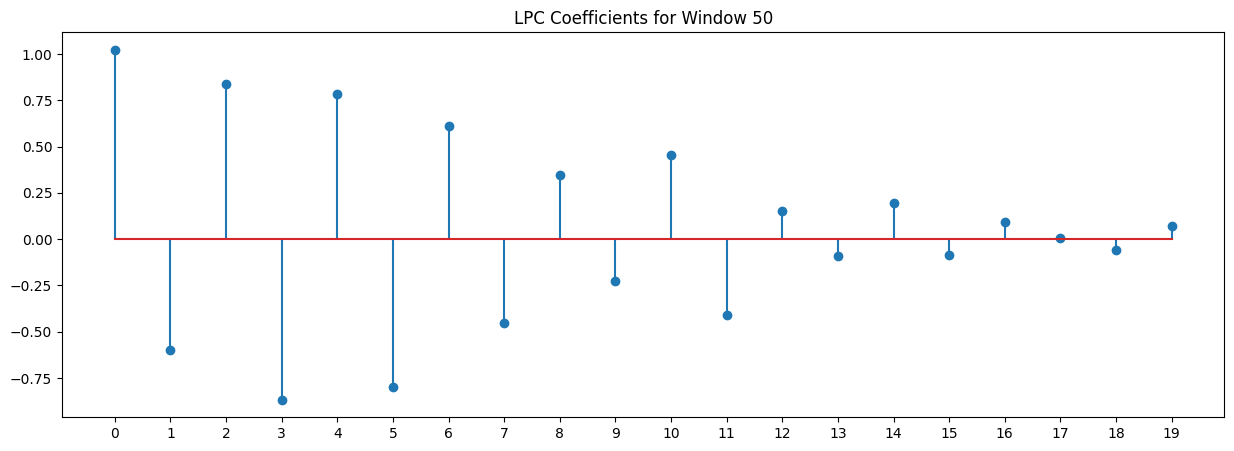

In [284]:
window_size = 0.025 # moving window size in seconds
overlap = 0.010 # overlap in seconds
window_len = int(window_size * fs)  # window length in samples
step = int(overlap * fs)  # step size in samples
window = np.hamming(window_len)
order = 20

lpc_coeffs = list()

for idx in range(0, len(audio_signal) - window_len, step):
    samples = audio_signal[idx:idx + window_len] * window
    lpc_coeffs.append(lpc_compute(samples, order=order))

WINDOW_TO_PLOT = 50
coeffs2plot = lpc_coeffs[WINDOW_TO_PLOT]

plt.figure(figsize=(15, 5))
plt.stem(coeffs2plot)
plt.xticks(np.arange(len(coeffs2plot)))
plt.title(f'LPC Coefficients for Window {WINDOW_TO_PLOT}')
plt.show()


Ejercicio 10

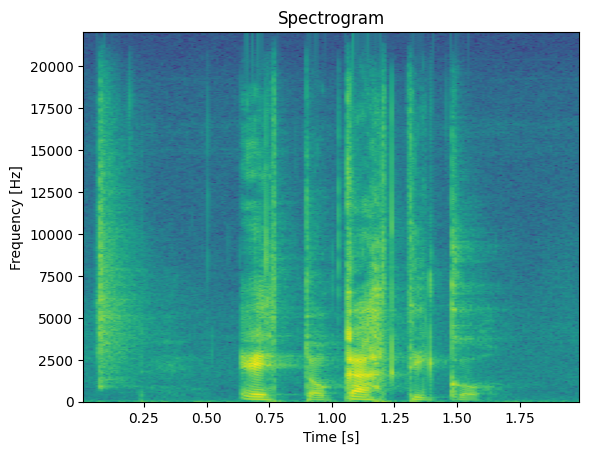

In [285]:
plt.specgram(
    audio_signal, NFFT=len(window), Fs=fs, noverlap=len(window) - step, window=window)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Spectrogram')
plt.show()

Ejercicio 11

Definir los espectros de los puntos analiticos y graficarlos 
con coeficientes lpc dados

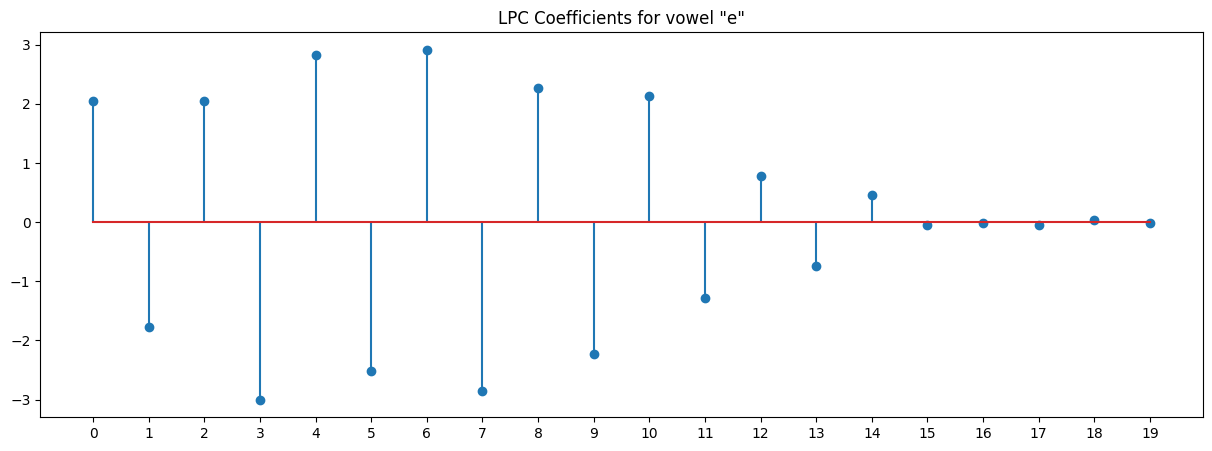

In [ ]:
e_samples = audio_signal[vowels['e'][0]:vowels['e'][1]][:window_len]
e_windowed = e_samples * window
e_lpc_coeffs = lpc_compute(e_windowed, order=order)

plt.figure(figsize=(15, 5))
plt.stem(e_lpc_coeffs)
plt.xticks(np.arange(len(e_lpc_coeffs)))
plt.title(f'LPC Coefficients for vowel "e"')
plt.show()

Ejercicio 12

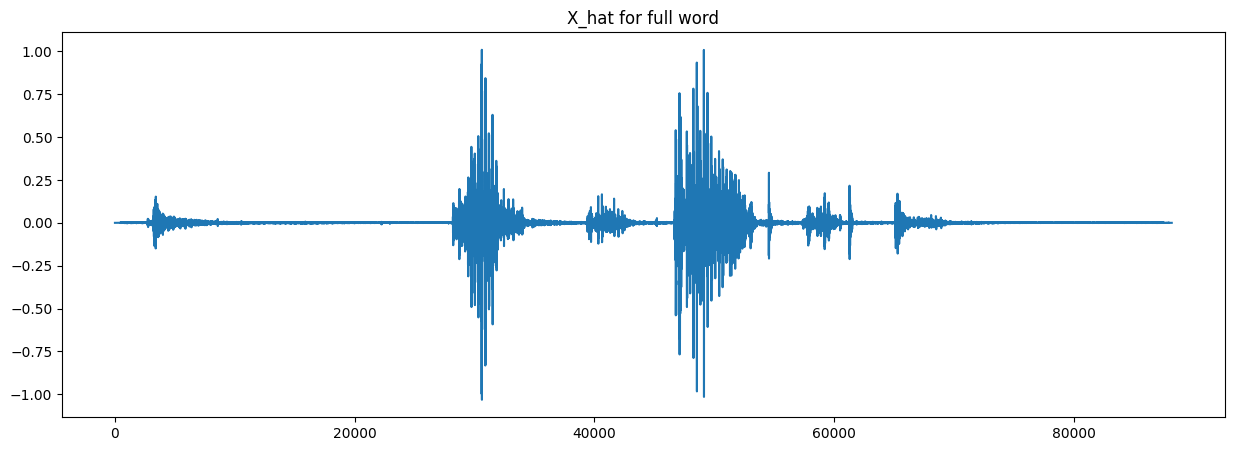

In [ ]:
x_hat_full_word = np.zeros_like(audio_signal)
for idx, lpc_window in zip(range(0, len(audio_signal) - window_len, step), lpc_coeffs):
    x_hat_window = excitation_signal(audio_signal[idx:idx + window_len], lpc_window)
    # sumamos las contribuciones de cada ventana para mitigar el efecto de borde
    x_hat_full_word[idx:idx + window_len] += x_hat_window

plt.figure(figsize=(15, 5))
plt.plot(x_hat_full_word)
plt.title('X_hat for full word')
plt.show()

Ejercicio 13

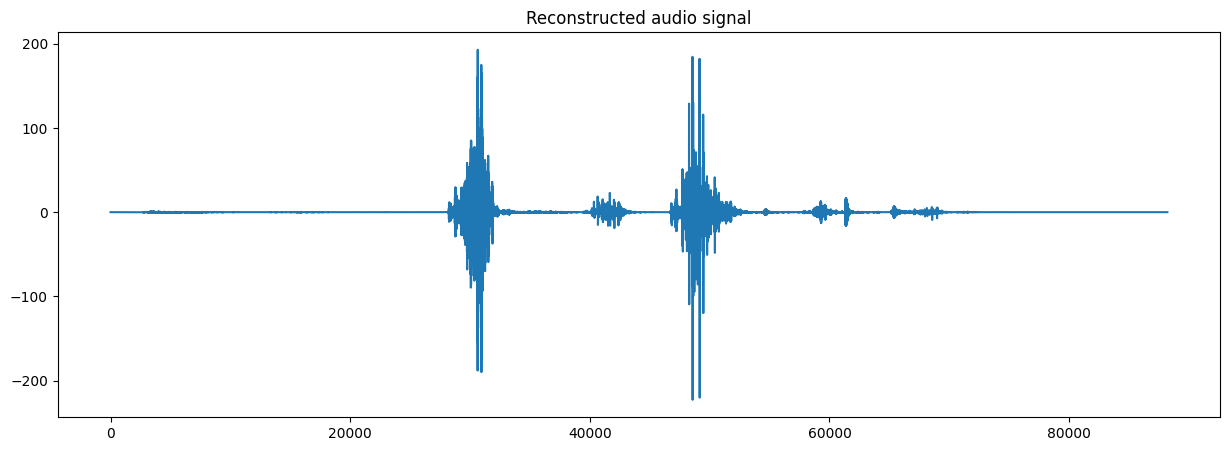

In [287]:
audio_reconstructed = np.zeros_like(audio_signal)
for idx, lpc_window in zip(range(0, len(audio_signal) - window_len, step), lpc_coeffs):
    audio_window = estimate_y_hat(
        x=x_hat_full_word[idx:idx + window_len], lpc_coeffs=lpc_window)
    # sumamos las contribuciones de cada ventana para mitigar el efecto de borde
    audio_reconstructed[idx:idx + window_len] += audio_window

plt.figure(figsize=(15, 5))
plt.plot(audio_reconstructed)
plt.title('Reconstructed audio signal')
plt.show()
IPython.display.Audio(audio_reconstructed, rate=fs)